In [41]:
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt


In [42]:
import tensorflow as tf
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
cd /content/drive/MyDrive/files

/content/drive/MyDrive/files


In [45]:
ls

imdb_data.csv  iris.csv  Katze_wikipedia_images.jpg  Used_Car_Dataset.csv  yelp.csv


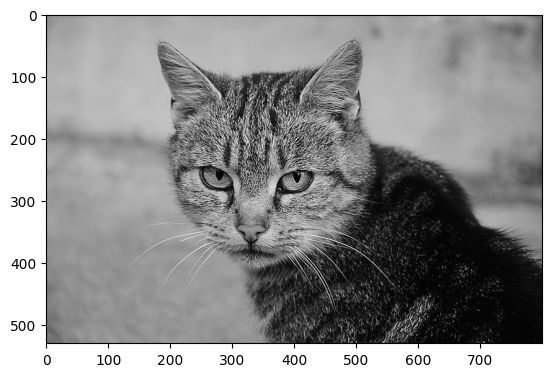

(530, 800)

In [46]:
img = cv2.imread("Katze_wikipedia_images.jpg", cv2.IMREAD_GRAYSCALE)/255
plt.imshow(img, cmap='gray')
plt.show()
img.shape

It is very important to know the output of convolutional layer, it can be calculated using the formula $\lfloor [\frac{W-K+2p}{S}] + 1 \rfloor$. Here<br>
*   $W$ is the input volume -- it can be either width or height
*   $K$ is the Kernel size
*   $P$ is the padding
*   $S$ is the stride

If you observe carefully the formula is wrapped in floor function i.e., if the value is $321.2$ then it will be considered as $321$.
The "Katze" image taken from the wikipedia is of the shape $530 \times 800$.  When the Convolutional neural network (CNN) is applied with kernel size($K$) as $3 \times 3$, with $0$ padding($P$) and stride size($S$) as $1$, its output is calculated as
*   Updated width is $\lfloor [\frac{530 - 3 + 2\times0}{1}] + 1 \rfloor = 528$
*   Updated height is $\lfloor [\frac{800 - 3 + 2\times0}{1}] + 1 \rfloor= 798$

The filters $K$ used in the CNN are randomly initialized and the backpropagation performed to update the filters, and its purpose is to extract the features from the image.

In [47]:
class Conv_op:
    def __init__(self, num_filters, filter_size):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.conv_filter = np.random.randn(num_filters, filter_size, filter_size)/(filter_size * filter_size)


    def image_region(self, image):
        height, width = image.shape
        self.image = image
        for j in range(height - self.filter_size + 1):
            for k in range(width - self.filter_size + 1):
                image_patch = image[j : (j + self.filter_size), k:(k + self.filter_size)]
                yield image_patch, j, k


    def forward_prop(self, image):
        height, width = image.shape
        conv_out = np.zeros((height - self.filter_size + 1, width - self.filter_size + 1, self.num_filters ))
        for image_patch, i, j in self.image_region(image):
            conv_out[i, j] = np.sum(image_patch * self.conv_filter, axis = (1,2))
        return conv_out


    def back_prop(self, dL_dout, learning_rate):
        dL_dF_params = np.zeros(self.conv_filter.shape)
        for image_patch, i, j in self.image_region(self.image):
            for k in range(self.num_filters):
                dL_dF_params[k] += image_patch*dL_dout[i,j,k]

        # Filter params update
        self.conv_filter -= learning_rate*dL_dF_params
        return dL_dF_params

In [48]:
conn = Conv_op(5, 3)
out = conn.forward_prop(img)
out.shape

(528, 798, 5)

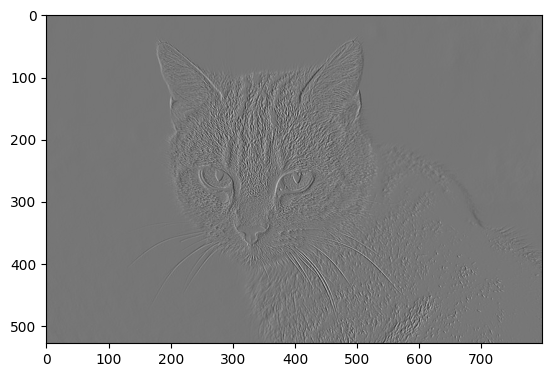

In [49]:
plt.imshow(out[:, :, 3], cmap = 'gray')
plt.show()

In [50]:
class Max_Pool:
    def __init__(self, filter_size):
        self.filter_size = filter_size

    def image_region(self, image):
        new_height = image.shape[0] //self.filter_size
        new_width = image.shape[1] //self.filter_size
        self.image = image

        for i in range(new_height):
            for j in range(new_width):
                image_patch = image[(i * self.filter_size) : (i * self.filter_size + self.filter_size), (j * self.filter_size) : (j * self.filter_size + self.filter_size)]
                yield image_patch, i, j

    def forward_prop(self, image):
        height, widhth, num_filters = image.shape
        output = np.zeros((height // self.filter_size, widhth // self.filter_size, num_filters))

        for image_patch, i, j in self.image_region(image):
            output[i, j] = np.amax(image_patch, axis = (0, 1))

        return output

    def back_prop(self, dL_dout):
        dL_dmax_pool = np.zeros(self.image.shape)
        for image_patch, i, j in self.image_region(self.image):
            height, width, num_filters = image_patch.shape
            maximum_val = np.amax(image_patch, axis =(0, 1))

            for i1 in range(height):
                for j1 in range(width):
                    for k1 in range(num_filters):
                        if image_patch[i1, j1, k1] == maximum_val[k1]:
                            dL_dmax_pool[i*self.filter_size + i1, j*self.filter_size + j1, k1] = dL_dout[i, j, k1]

        return dL_dmax_pool

In [51]:
conn2 = Max_Pool(4)
out2 = conn2.forward_prop(out)
print(out2.shape)

(132, 199, 5)


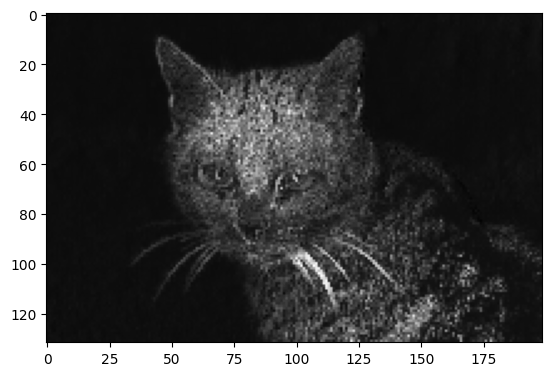

In [52]:
plt.imshow(out2[:, :, 3], cmap = 'gray')
plt.show()

In [53]:
class Softmax:
    def __init__(self, input_node, softmax_node):
        self.weight = np.random.randn(input_node, softmax_node)/input_node
        self.bias = np.zeros(softmax_node)

    def forward_prop(self, image):

        self.orig_im_shape = image.shape # used in backprop
        image_modified = image.flatten()
        self.modified_input = image_modified # to be used in backprop
        output_val = np.dot(image_modified, self.weight) + self.bias
        self.out = output_val
        exp_out = np.exp(output_val)
        return exp_out/np.sum(exp_out, axis=0)

    def back_prop(self, dL_dout, learning_rate):
        for i, grad in enumerate(dL_dout):
            if grad == 0:
                continue

            transformation_eq = np.exp(self.out)
            S_total = np.sum(transformation_eq)

            #Gradients with respect to out (z)
            dy_dz = -transformation_eq[i]*transformation_eq / (S_total **2)
            dy_dz[i] = transformation_eq[i]*(S_total - transformation_eq[i]) / (S_total **2)

            #Gradients of totals agianst weights/biases/input
            dz_dw = self.modified_input
            dz_db = 1
            dz_d_inp = self.weight

            #Gradients of loss against totals
            dL_dz = grad * dy_dz

            #Gradients of loss against weights/biases/input
            dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]
            dL_db = dL_dz * dz_db
            dL_d_inp = dz_d_inp @ dL_dz

            # Update weights and biases
            self.weight -= learning_rate * dL_dw
            self.bias -= learning_rate *dL_db

            return dL_d_inp.reshape(self.orig_im_shape)

In [54]:
conn3 = Softmax(132*199*5, 10)
out3 = conn3.forward_prop(out2)
print(out3)

[0.09998642 0.09994036 0.10003569 0.10006174 0.10001753 0.10000339
 0.09997022 0.09995077 0.09997713 0.10005675]


In [55]:
train_images = train_images[: 1500]
train_labels = train_labels[: 1500]
test_images = test_images[: 1500]
test_labels = test_labels[: 1500]

In [56]:
conv = Conv_op(8, 3)                  # 28x28x1 -> 26x26x8
pool = Max_Pool(2)                    # 26x26x8 -> 13x13x8
softmax = Softmax(13 * 13 * 8, 10)    # 13x13x8 -> 10


In [57]:
def cnn_forward_prop(image, label):
    out_p = conv.forward_prop((image/255) - 0.5)
    out_p = pool.forward_prop(out_p)
    out_p = softmax.forward_prop(out_p)

    # Calculate cross-entropy loss and accuracy.
    cross_ent_loss = -np.log(out_p[label])
    accuracy_eval = 1 if np.argmax(out_p) -- label else 0

    return out_p, cross_ent_loss, accuracy_eval

def training_cnn(image, label, learn_rate=0.005):

    #Forward
    out, loss, acc = cnn_forward_prop(image, label)

    #Calculate initial gradient
    gradient = np.zeros(10)
    gradient[label] = -1 / out[label]

    # Backprop
    grad_back = softmax.back_prop(gradient, learn_rate)
    grad_back = pool.back_prop(grad_back)
    grad_back = conv.back_prop(grad_back, learn_rate)

    return loss, acc

In [58]:
for epoch1 in range(4):
    print('Epoch %d ----->' % (epoch1 + 1))

    # Shuffle the training data
    shuffle_data = np.random.permutation(len(train_images))
    train_images = train_images[shuffle_data]
    train_labels = train_labels[shuffle_data]

    #Training the CNN
    loss = 0
    num_correct = 0
    for i, (im, label) in enumerate(zip(train_images, train_labels)):
        if i % 100 == 0:
            print('%d steps out of 100 steps: Average Loss %.3f and Accuracy: %d%%' % (i+1, loss/100, num_correct))
            loss = 0
            num_correct = 0

        l1, accu =  training_cnn(im, label)
        loss += l1
        num_correct += accu

Epoch 1 ----->
1 steps out of 100 steps: Average Loss 0.000 and Accuracy: 0%


<ipython-input-57-489e72e25dee>:8: RuntimeWarning: overflow encountered in scalar negative
  accuracy_eval = 1 if np.argmax(out_p) -- label else 0


101 steps out of 100 steps: Average Loss 2.033 and Accuracy: 100%
201 steps out of 100 steps: Average Loss 1.573 and Accuracy: 90%
301 steps out of 100 steps: Average Loss 1.036 and Accuracy: 94%
401 steps out of 100 steps: Average Loss 0.780 and Accuracy: 95%
501 steps out of 100 steps: Average Loss 1.147 and Accuracy: 95%
601 steps out of 100 steps: Average Loss 0.755 and Accuracy: 94%
701 steps out of 100 steps: Average Loss 0.906 and Accuracy: 89%
801 steps out of 100 steps: Average Loss 1.128 and Accuracy: 92%
901 steps out of 100 steps: Average Loss 0.803 and Accuracy: 95%
1001 steps out of 100 steps: Average Loss 0.589 and Accuracy: 93%
1101 steps out of 100 steps: Average Loss 0.875 and Accuracy: 95%
1201 steps out of 100 steps: Average Loss 0.769 and Accuracy: 97%
1301 steps out of 100 steps: Average Loss 0.730 and Accuracy: 91%
1401 steps out of 100 steps: Average Loss 0.779 and Accuracy: 90%
Epoch 2 ----->
1 steps out of 100 steps: Average Loss 0.000 and Accuracy: 0%
101 ste

In [59]:
# Testing the CNN
print('**Testting phase')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
    _, l1, accu = cnn_forward_prop(im, label)
    loss += l1
    num_correct += accu

num_tests = len(test_images)
print('Test Loss', loss/num_tests)
print('Test accuracy:', num_correct/num_tests)

**Testting phase


<ipython-input-57-489e72e25dee>:8: RuntimeWarning: overflow encountered in scalar negative
  accuracy_eval = 1 if np.argmax(out_p) -- label else 0


Test Loss 0.6144419832792684
Test accuracy: 0.9193333333333333
